# Assignment 7: Backpropagation
Read the Rojas book (https://page.mi.fu-berlin.de/rojas/neural/neuron.pdf), chapter 7.3.3 and learn about the "matrix way" of implementing backprop. 

In [0]:
%matplotlib inline

import sys
import tqdm
import numpy as np
import numpy.random as nprd
import torch
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

mnist_train_data = mnist_train.data.numpy()
mnist_train_labels = mnist_train.targets.numpy()
mnist_test_data = mnist_test.data.numpy()
mnist_test_labels = mnist_test.targets.numpy()

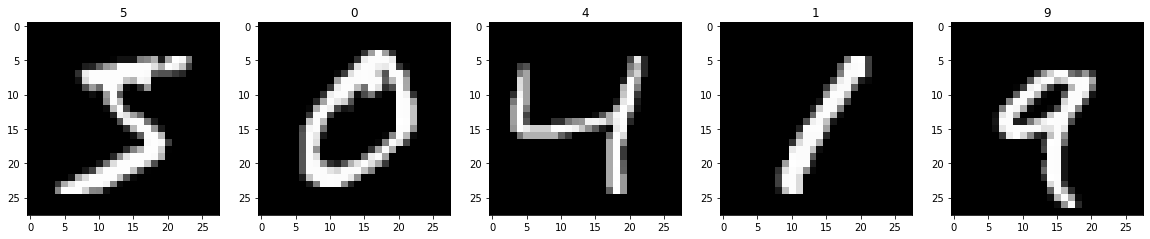

In [49]:
images, labels = mnist_train_data[:5], mnist_train_labels[:5]

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    axes[i].set_title(labels[i])
    axes[i].imshow(images[i], cmap='gray')

## Ex. 7.1 XOR
Implement a two-layer artificial neural network with two input neurons and one output neuron. Choose the number of hidden neurons to your liking and add an error "neuron" to your network. Our goal is to learn the XOR function. What does the network return for random weights of all combinations of (binary) inputs? **(RESULT)**

First of all, we define some help functions:

In [0]:
def normalize(data, mean=None, variance=None, ret=False):
    """Normalizes the data to allow for faster convergence of the gradient ascent"""
    if mean is None:
        mean = np.mean(data, axis=0)[np.newaxis,:]
    if variance is None:
        std = np.std(data, axis=0)[np.newaxis,:]
    std[np.where(std == 0)] = 1
    data_ = (data - mean) / std
    if ret:
        return data_
    else:
        return data_, mean, std

def onehot(labels, k):
    n = len(labels)
    onehot_labels = np.zeros([n, k])
    onehot_labels[range(n), labels] = 1
    return onehot_labels

def glorot_initialize(shape):
    assert len(shape) == 2
    fan_in, fan_out = shape
    std = np.sqrt(2.0 / (fan_in + fan_out))
    W = np.random.normal(loc=0.0, scale=std, size=shape)
    return W

def getMiniBatches(data, target, batch_size, shuffle=False):
    assert len(data) == len(target)
    permutation = np.random.permutation(len(data))
    for index in range(0, len(data), batch_size):
        low = index
        high = min(len(data), low + batch_size)
        indices = permutation[low:high]
        yield data[indices], target[indices]

class NNFunction:
    def __init__(self, function, derivative):
        assert callable(function) and callable(derivative)
        self.f = function
        self.df = derivative
  
  def __call__(self, x, df=False):
    if df:
        return self.df(x)
    else:
        return self.f(x)

class Sigmoid(NNFunction):
    def __init__(self):
        sigmoid = lambda x: 1/2 * (1 + torch.tanh(1/2 * x))
        sigmoid_ = lambda x: sigmoid(x) * (1 - sigmoid(x))
        super(Sigmoid, self).__init__(sigmoid, sigmoid_)

In [0]:
class NeuronNetwork:
    def __init__(self, pcount):
        N = len(pcount)
        self.W = [torch.from_numpy(glorot_initialize([pcount[i-1]+1, pcount[i]])).float() for i in range(1, N)]
        
    def train(self, data, targets, batch_size=None, itlimit=1000, ret=True, lr=1e-3):
        if batch_size is None:
            batch_size = len(data)
        
        #Initialize iteration parameters:
        t = 0
        acc, err = [], []

        while(t < itlimit):
            err_avg, acc_avg = 0, 0
            for batch_count, (batch_data, batch_labels) in enumerate(getMiniBatches(data, targets, batch_size, shuffle=True)):
                x = torch.from_numpy(batch_data).float()
                y = torch.from_numpy(batch_labels).float()
                o = torch.cat([x, torch.ones([x.shape[0], 1])], axis=1)

                #Calculate hidden-layer and output-layer output:
                ol = self.feedforward(o)
                #Calculate backprop errors of both layers:
                dl = self.backprop(y, ol)
                #Using backprop errors, calculate new weights
                self.optimize(o, ol, dl, lr)
                
                y_max, y_max_idx = torch.max(y, axis=1)
                o_max, o_max_idx = torch.max(ol[-1], axis=1)
                err_avg += torch.mean(torch.sum((y - ol[-1])**2, axis=0))
                acc_avg += torch.mean((y_max_idx == o_max_idx).float())
                
            err.append(err_avg / (batch_count + 1))
            acc.append(acc_avg / (batch_count + 1))
            t += 1
            
            sys.stdout.write('\r{}/{} iterations, error: {}, accuracy: {}, learning rate: {}'.format(t, itlimit, err[-1], acc[-1], lr))
        print('\nDone!')
        if(ret):
            return(err)
            
    def feedforward(self, o, W=None):
        """Feed-forward given input o and weight matrices W1 and W2."""
        if(W is None):
            W = self.W
        o1 = self.sigmoid(torch.matmul(o, W[0]))
        ol = [torch.cat([o1, torch.ones([o1.shape[0], 1])], axis=1)]
        for i in range(1, len(W)-1):
            oi = self.sigmoid(torch.matmul(ol[-1], W[i]))
            ol.append(torch.cat([oi, torch.ones([oi.shape[0], 1])], axis=1))
        ol.append(self.sigmoid(torch.matmul(ol[-1], W[-1])))
        return(ol)

    def backprop(self, y, ol):
        dl =[ol[-1] * (1 - ol[-1]) * (y - ol[-1])]
        dl.insert(0, ol[-2] * (1 - ol[-2]) * torch.matmul(dl[0], torch.transpose(self.W[-1], 0, 1)))
        for i in reversed(range(len(ol)-2)):
            d = ol[i] * (1 - ol[i]) * torch.matmul(dl[0][:,:-1], torch.transpose(self.W[i+1], 0, 1))
            dl.insert(0, d)
        return(dl)

    def optimize(self, o, ol, dl, lr):
        dW = [torch.matmul(torch.transpose(o, 0, 1), dl[0][:,:-1])]
        for i in range(1, len(ol)-1):
            dWi = torch.matmul(torch.transpose(ol[i-1], 0, 1), dl[i][:,:-1])
            dW.append(dWi)
        dW.append(torch.matmul(torch.transpose(ol[-2], 0, 1), dl[-1]))

        for i in range(len(self.W)):
            self.W[i] += lr * dW[i]
        
    def eval(self, data):
        """Classifies a set of data vectors, returning a list of the labels assigned"""
        x = torch.from_numpy(data).float()
        o = torch.cat([x, torch.ones([data.shape[0], 1])], axis=1)
        ol = self.feedforward(o)
        y, y_idx = torch.max(ol[-1], axis=1)
        return(y_idx)
        
    def sigmoid(self, x):
        """The sigmoidal functinon as defined by the numerically more stable tanh"""
        return(1/2 * (1 + torch.tanh(1/2 * x)))

In [219]:
xor_data = np.array([
  [0,0],
  [0,1],
  [1,0],
  [1,1],
])
xor_labels = onehot(np.array([0, 1, 1, 0]), 2)
xor_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]])

For a random Glorot initialization, the network returns a random output:

In [223]:
for i in range(10):
    model = NeuronNetwork([2, 4, 2])
    print(model.eval(xor_data))

tensor([0, 0, 0, 0])
tensor([1, 1, 1, 1])
tensor([0, 0, 0, 0])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([1, 1, 1, 1])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([1, 1, 1, 1])


## Ex. 7.2 Backpropagation
Implement Backpropagation and optimize the weights of your neural network using the XOR training set: 

#### x, y

(0,0), 0 

(0,1), 1

(1,0), 1

(1,1), 0

How many training iterations do you need? Plot the network error over the number of iterations! **(RESULT)**

We now proceed to train the network.

In [227]:
model = NeuronNetwork([2,4,2])
errs = model.train(xor_data, xor_labels, batch_size=4, itlimit=20000, lr=1e-1)

20000/20000 iterations, error: 0.0018696167971938848, accuracy: 1.0, learning rate: 0.1
Done!


Evaluating the model after training, we can see that it has indeed learned the XOR function:

In [228]:
model.eval(xor_data)

tensor([0, 1, 1, 0])

The error decreases in the typical fashion for neural nets, with a quick initial decrease that eventually flattens out. Training requires less than 10000 iterations using a step size of 0.01.

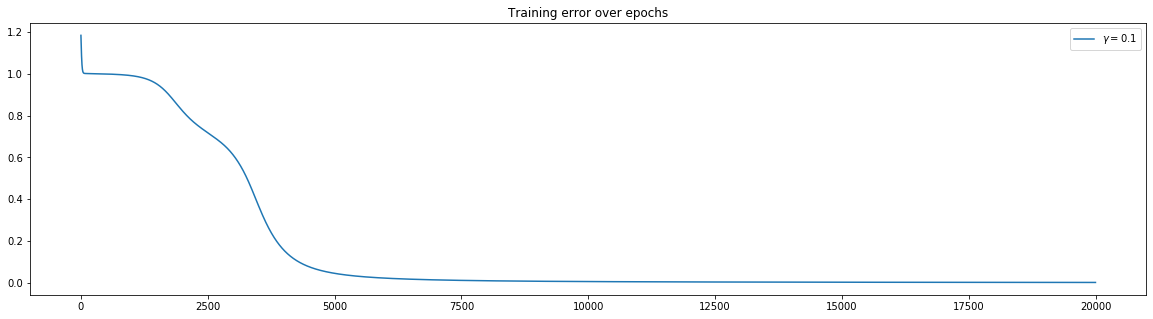

In [229]:
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.set_title("Training error over epochs")
ax.plot(errs, label="$\gamma = 0.1$")
plt.legend()

# Ex. 7.3 MNIST (BONUS)
Train your network on the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) and state the model accuracy (or the model error) for the training and test sets. **(RESULT)** Compare to this [list](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354)


In [0]:
mnist_train_data_ = mnist_train_data.reshape([-1, 28*28])
mnist_train_labels_ = onehot(mnist_train_labels, 10)

To speed up convergence, we normalize the training data before starting the training:

In [231]:
mnist_train_data_, mean, mu = normalize(mnist_train_data.reshape([-1, 28*28]))
mnist_train_labels_ = onehot(mnist_train_labels, 10)

mnist_model = NeuronNetwork([28 * 28, 10, 10])
errs = mnist_model.train(mnist_train_data_, mnist_train_labels_, itlimit=500, batch_size=None, lr=1e-4)

500/500 iterations, error: 809.7964477539062, accuracy: 0.9260833263397217, learning rate: 0.0001
Done!


While our result is reasonably good, it is still far from top performances, for which the error is virtually zero. To achieve such performance, deeper network architectures with convolutions are required.

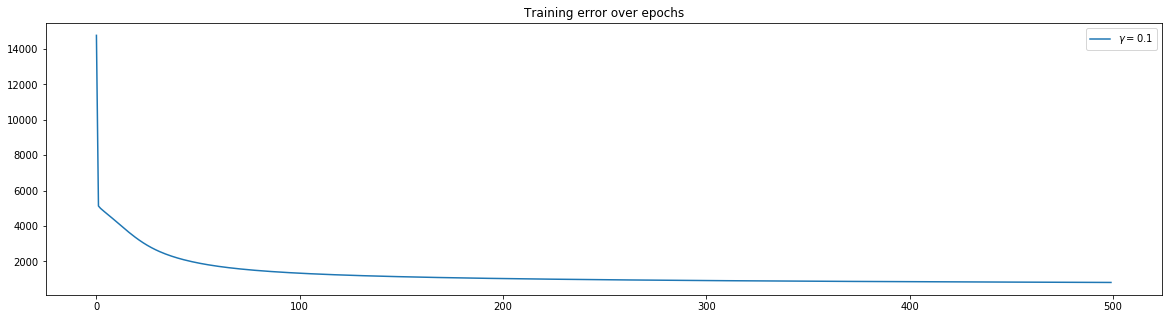

In [232]:
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.set_title("Training error over epochs")
ax.plot(errs, label="$\gamma = 0.1$")
plt.legend()